<a href="https://colab.research.google.com/github/conradder/COM667/blob/master/COM739_17952_CW3(Fearon%2CConor_b00699799).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Initial Setup**

1. First, you will setup your CoLab environment. Run the cell below.

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 198 kB 30.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=f2653df30113c564787847636825e3fd1cf93e5e6b0e81391da4dab59f31ff3b
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Rea

Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Download both anime.csv and rating.csv, and store it in your google drive. It is advisable to create a separate project folder, where you can store this dataset and also your code.

The script will give you the id of the two files in your drive.

In [ ]:
file_list = drive.ListFile({'q': "'1Oi8cMnAfJVZH9-FyXGxwOrGGCIkkB7uy' in parents"}).GetList()
for f in file_list:
  print('title: %s, id: %s' % (f['title'], f['id']))

title: rating.csv, id: 1f76dQZxRB1fNaReBv_DnUDVkIXNm7mw9
title: anime.csv, id: 1TppJoj4QVJlc_HML20xmH847Brrw0Zfc


If you executed the cells below, you should be able to see the dataset we will need for this Colab under the "Files" tab on the left panel.

In [ ]:
# Change the id, if it differs from the one below.
id='1TppJoj4QVJlc_HML20xmH847Brrw0Zfc'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('anime.csv')

id='1f76dQZxRB1fNaReBv_DnUDVkIXNm7mw9'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('rating.csv')

Here is a list of packages that might be useful to you. 

**Student Activity: Add the packages you need to carry out your analysis here** 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Student Activity: Add your packages here.
import math
from pyspark import SparkContext, SparkConf
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns


**This step initializes the Spark context.**

In [ ]:
# create the session
#conf = SparkConf().set("spark.ui.port", "4050")


# create the context
#sc = pyspark.SparkContext(conf=conf)

#spark = SparkSession.builder.getOrCreate()

conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a local runtime).

In [ ]:
spark

## **From this point onwards, you are supposed to do the coding yourself. Follow the steps as mentioned below in its appropriate place.**

**1. Student Activity: Read the datasets here. You must write the script for the first question and explore both the files here.**

Q1. Identify and describe the number of columns in the two dataset files.

I will bring the CSV files in as an RDD and use printSchema() to display the column names and data type for each column. Note the datatype for episodes is a string.

In [ ]:
#bring the rating csv files as rdd and show shcema (inc headers and schema)
ratings = spark.read.csv("rating.csv", header=True, inferSchema = True)
ratings.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [ ]:
#bring the anime csv files as rdd and show shcema  (inc headers and schema)
anime  = spark.read.csv("anime.csv", header=True, inferSchema = True)
anime.printSchema()

root
 |-- anime_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- type: string (nullable = true)
 |-- episodes: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- members: integer (nullable = true)



I will use count() and len() to get the number of rows and number of columns 

In [ ]:

print("Number of rows in each rdd:\n *Anime:\t", anime.count(), "\n *ratings:\t" , ratings.count())
print("Number of Columns in each rdd:\n *Anime:\t", len(anime.columns), "\n *ratings:\t" , len(ratings.columns))


Number of rows in each rdd:
 *Anime:	 12294 
 *ratings:	 7813737
Number of Columns in each rdd:
 *Anime:	 7 
 *ratings:	 3


.describe.show() will give an overview of each RDD. Note the min rating in ratings is '-1' and max value of episodes in anime is 'unknown'

In [ ]:
ratings.describe().show()

+-------+------------------+-----------------+------------------+
|summary|           user_id|         anime_id|            rating|
+-------+------------------+-----------------+------------------+
|  count|           7813737|          7813737|           7813737|
|   mean|36727.956744640884|8909.072104295294| 6.144029546937656|
| stddev|20997.946118973723| 8883.94963588107|3.7278004201098067|
|    min|                 1|                1|                -1|
|    max|             73516|            34519|                10|
+-------+------------------+-----------------+------------------+



In [ ]:
anime.describe().show()
#note string in episodes!

+-------+------------------+-----------------+------+-----+------------------+-----------------+-----------------+
|summary|          anime_id|             name| genre| type|          episodes|           rating|          members|
+-------+------------------+-----------------+------+-----+------------------+-----------------+-----------------+
|  count|             12294|            12294| 12232|12269|             12294|            12064|            12294|
|   mean|14058.221652838783|         166778.5|  null| null|12.382549774134182|6.473901690981445|18071.33886448674|
| stddev|11455.294700988177|330891.6746051493|  null| null| 46.86535196440979|1.026746306898068|54820.67692490701|
|    min|                 1|    &quot;0&quot;|Action|Movie|                 1|             1.67|                5|
|    max|             34527|                ◯|  Yaoi|   TV|           Unknown|             10.0|          1013917|
+-------+------------------+-----------------+------+-----+------------------+--

I believe a rating of -1 shouldn't be counted as these represent movies watched but not rated - therefore dont 'represent' a number rating. I will run a query to see the distribution of ratings. The table and plot below show the -1's would skew any calculation on the ratings so should be removed. Once removed the ratings would be normally distributed 

+------+-------+
|rating|  count|
+------+-------+
|    -1|1476496|
|     1|  16649|
|     2|  23150|
|     3|  41453|
|     4| 104291|
|     5| 282806|
|     6| 637775|
|     7|1375287|
|     8|1646019|
|     9|1254096|
|    10| 955715|
+------+-------+



Text(0, 0.5, 'Count (million)')

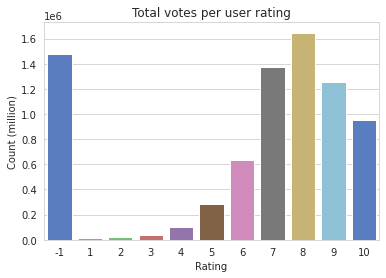

In [ ]:
ratings.createOrReplaceTempView("ratings")

s = spark.sql("SELECT rating, count(rating) as count FROM ratings group by rating order by rating ")
s.show()
s = s.toPandas()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=None)
ax = sns.barplot(x='rating', y='count', data=s, ci=None, palette="muted",orient='v')
ax.set_title("Total votes per user rating")
ax.set_xlabel ("Rating")
ax.set_ylabel ("Count (million)")


**2. Student Activity: Preprocess the datasets here. You must write the script for the second question here. Make sure to check if the script is running is correctly or not**

Q2. Merge/Join/Combine the two datasets and identify the key common column that would you have performed? 

Note: i used an inner join as these would discount any anime_id not in ratings and vice versa. 

In [ ]:
#inner join
anime_ratings = ratings.join(anime, ratings.anime_id == anime.anime_id, 'inner')
anime_ratings.show()
# count shows 10 anime ID in ratings not in anime!!!

+-------+--------+------+--------+--------------------+--------------------+-----+--------+------+-------+
|user_id|anime_id|rating|anime_id|                name|               genre| type|episodes|rating|members|
+-------+--------+------+--------+--------------------+--------------------+-----+--------+------+-------+
|      1|      20|    -1|      20|              Naruto|Action, Comedy, M...|   TV|     220|  7.81| 683297|
|      1|      24|    -1|      24|       School Rumble|Comedy, Romance, ...|   TV|      26|  8.06| 178553|
|      1|      79|    -1|      79|            Shuffle!|Comedy, Drama, Ec...|   TV|      24|  7.31| 158772|
|      1|     226|    -1|     226|          Elfen Lied|Action, Drama, Ho...|   TV|      13|  7.85| 623511|
|      1|     241|    -1|     241|Girls Bravo: Firs...|Comedy, Ecchi, Fa...|   TV|      11|  6.69|  84395|
|      1|     355|    -1|     355|   Shakugan no Shana|Action, Drama, Fa...|   TV|      24|  7.74| 297058|
|      1|     356|    -1|     356|   

**3. Student Activity: Now do some exploratory analysis. You must write the script for the third and fourth question here. Make sure to check if the script is running is correctly or not**


In [ ]:
anime_ratings.count()==ratings.count()

False

The number of rows in the joined table doens't match the number of rows in the ratings RDD. This would suggest there were Anime_ID in ratings that were not in the anime table. 

Q3. Find the top 10 anime based on rating. Use tabular/graphical presentation to provide evidence of your analysis.

**I undertook three different methods to produce a “Top 10 Anime”**. 

First was a simple query on the Anime RDD where I selected the Anime name and rating, ordered by rating in descending order.

In [ ]:
anime.select('name', 'rating').where((col("rating").isNotNull())).sort(col("rating").desc()).show(10, truncate=False) #a simple query to select name and rating column form anime table, order by rating... 

+---------------------------------------+------+
|name                                   |rating|
+---------------------------------------+------+
|Taka no Tsume 8: Yoshida-kun no X-Files|10.0  |
|Spoon-hime no Swing Kitchen            |9.6   |
|Mogura no Motoro                       |9.5   |
|Kimi no Na wa.                         |9.37  |
|Kahei no Umi                           |9.33  |
|Fullmetal Alchemist: Brotherhood       |9.26  |
|Yakusoku: Africa Mizu to Midori        |9.25  |
|Gintama°                               |9.25  |
|Steins;Gate                            |9.17  |
|Gintama&#039;                          |9.16  |
+---------------------------------------+------+
only showing top 10 rows



My second method took a pure average rating based on Ratings RDD. I created an RDD with a query that removed any ratings with a ‘-1’ value. It also used an aggerate function, avg(), which gave a mean value for each anime_id and grouped these anime_id together. I joined this to the Anime RDD and selected the anime name and my calculated mean rating, ordered in descending order.

In [ ]:
mean_rating = ratings.where(col('rating')>-1).groupBy('anime_id').agg(avg('rating').alias('avg_rating')) #remove -1 and averge the rest per anime id
anime_mean_ratings = mean_rating.join(anime, mean_rating.anime_id == anime.anime_id, 'inner') # inner join to anime to get name info (and remove any that dont appear in both tables)
anime_mean_ratings.select('name', round(col('avg_rating'),2).alias('avg_rating')).sort(col("rating").desc()).show(10, truncate=False)


+---------------------------------------------------------+----------+
|name                                                     |avg_rating|
+---------------------------------------------------------+----------+
|Kimi no Na wa.                                           |9.43      |
|Fullmetal Alchemist: Brotherhood                         |9.32      |
|Gintama°                                                 |9.45      |
|Steins;Gate                                              |9.26      |
|Gintama&#039;                                            |9.27      |
|Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou|9.17      |
|Hunter x Hunter (2011)                                   |9.23      |
|Gintama&#039;: Enchousen                                 |9.2       |
|Ginga Eiyuu Densetsu                                     |9.39      |
|Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare      |9.19      |
+---------------------------------------------------------+----------+
only s

My third method was based on the formula used by IMDb to calculate their Top 250 titles - see appendix

My next step was to create an RDD called eligableAnime – I created a SparkSQL instance which returned anime_id, an aggarate function which counted the number of ratings made against it, an aggarate function which returned the mean rating and a sub query which returned the mean rating of the whole table. I only included anime with over 100 votes, unlike IMDb which is 25,000. I inner joined this with eligible users so only their votes are counted. 
Once I had my dataset I created another SparkSQL instance to calculate the Weighted Average and joined it to the Anime RDD. I selected the anime name and ordered by rating in descending order.


In [ ]:

ratings.createOrReplaceTempView("ratings") #create temp view from rdd
eligableUsers = spark.sql(("SELECT user_id   FROM ratings where rating> -1 group by user_id having count(user_id)>10 ")) #sql instance - determine eligable users by selecting user ids with 10 votes greater than -1
eligableAnime = spark.sql(("SELECT anime_id, count(anime_id) as animeRatingCount, round(avg(rating), 2) as averageRating FROM ratings where rating >-1 and user_id in (SELECT user_id FROM ratings where rating> -1 group by user_id having count(user_id)>10 )group by anime_id having count(anime_id)>100")) 
#determine eligable anime, with over 100 votes (greater that -1) and only counting eligable users. also includes average and number of ratings
eligableAnime.show()

+--------+----------------+-------------+
|anime_id|animeRatingCount|averageRating|
+--------+----------------+-------------+
|    8086|            3837|         7.94|
|   17389|             757|          8.6|
|    2866|             229|         7.15|
|    5300|            3814|         8.69|
|   30654|            2379|         8.69|
|    1088|            1127|         8.18|
|    1829|            2638|         7.34|
|    1238|             698|         7.68|
|    1342|             140|         6.03|
|   17679|             116|         7.29|
|    2142|             481|         6.68|
|     463|            1678|          7.6|
|   25517|             697|         8.09|
|    1591|             275|         6.36|
|    9465|            1942|          8.1|
|   22097|             909|         8.13|
|   11033|             253|         7.41|
|    6336|             711|         8.49|
|     471|             388|         6.85|
|   33569|             137|         7.11|
+--------+----------------+-------

In [ ]:
ratings.where(col('rating')>-1).agg(round(avg('rating'),2)).take(1) #gets the average rating across whole report


[Row(round(avg(rating), 2)=7.81)]

In [ ]:
#create temp view from rdd
ratings.createOrReplaceTempView("ratings") #create temp view from rdd
#sql instance - determine eligable users by selecting user ids with 10 votes greater than -1
eligableUsers = spark.sql(("SELECT user_id  FROM ratings where rating> -1 group by user_id having count(user_id)>10 "))
#create temp view from rdd
eligableUsers.createOrReplaceTempView("eligableUsers")
#determine eligable anime, with over 100 votes (greater that -1) and only counting eligable users buy joining table. also includes average and number of ratings and a column showing the mean across whole report
eligableAnime = spark.sql(("SELECT anime_id, count(anime_id) as c, round(avg(rating),2) as a, (select round(avg(rating),2)from ratings where rating >-1) as m FROM ratings inner join eligableUsers on eligableUsers.user_id = ratings.user_id group by anime_id having count(anime_id)>100 "))
#create temp view from rdd
eligableAnime.createOrReplaceTempView("eligableAnime")
#gets weighted average by using formula
weightedRating = spark.sql("select anime_id, round(((a*c)+(m*100))/(c+100),2) as weightedAverage from eligableAnime")
weightedRating.show()

+--------+---------------+
|anime_id|weightedAverage|
+--------+---------------+
|    8086|           7.13|
|   17389|           7.62|
|    2866|            5.9|
|    5300|           7.76|
|   30654|           7.62|
|    1088|           7.17|
|    1829|           6.57|
|    1238|           6.08|
|    1342|           6.46|
|   17679|           6.95|
|    2142|           6.04|
|     463|           6.11|
|   25517|           7.07|
|    1591|           5.93|
|    9465|           6.94|
|   22097|           7.03|
|   11033|           6.15|
|    6336|           7.75|
|     471|           6.01|
|   33569|           6.49|
+--------+---------------+
only showing top 20 rows



In [ ]:
#for comparison sakes....
weightedRating.join(mean_rating, weightedRating.anime_id == mean_rating.anime_id, 'inner').show()


+--------+---------------+--------+------------------+
|anime_id|weightedAverage|anime_id|        avg_rating|
+--------+---------------+--------+------------------+
|    8086|           7.13|    8086| 7.939071817474721|
|   17389|           7.62|   17389| 8.601839684625492|
|    2866|            5.9|    2866|7.1645021645021645|
|    5300|           7.76|    5300| 8.694010416666666|
|   30654|           7.62|   30654| 8.687342833193629|
|    1088|           7.17|    1088| 8.186784140969163|
|    1829|           6.57|    1829| 7.341757827235005|
|    1238|           6.08|    1238| 7.679542203147354|
|    1342|           6.46|    1342| 6.035460992907802|
|   17679|           6.95|   17679| 7.293103448275862|
|    2142|           6.04|    2142|6.6969072164948455|
|     463|           6.11|     463| 7.601311084624553|
|   25517|           7.07|   25517| 8.091559370529328|
|    1591|           5.93|    1591|              6.36|
|    9465|           6.94|    9465| 8.098352214212152|
|   22097|

In [ ]:
#joining with anime rdd to get names and dsiplay top 10
weightedAnime = anime.join(weightedRating, weightedRating.anime_id == anime.anime_id, 'inner')
weightedAnime.select('name', 'weightedAverage').sort(col('weightedAverage').desc()).show(10, truncate=False)



+----------------------------------+---------------+
|name                              |weightedAverage|
+----------------------------------+---------------+
|Steins;Gate                       |8.78           |
|Kimi no Na wa.                    |8.78           |
|Fullmetal Alchemist: Brotherhood  |8.77           |
|Ginga Eiyuu Densetsu              |8.7            |
|Hunter x Hunter (2011)            |8.63           |
|Clannad: After Story              |8.6            |
|Code Geass: Hangyaku no Lelouch R2|8.51           |
|Gintama                           |8.47           |
|Gintama°                          |8.46           |
|Tengen Toppa Gurren Lagann        |8.43           |
+----------------------------------+---------------+
only showing top 10 rows



~~Q4. Find the top 10 anime with the most episodes. Use tabular/graphical presentation to provide evidence of your analysis.~~


This question was included in error, but i answered it anyway.

I had to clean the Anime data before getting the result. PrintSchema() showed that the datatype for Episodes was a string. When I ran anime.describe().show(). I noticed that the maximum value of Episodes was “unknown”. First I removed these “unknown” values and then converted the column to integer. I ran a pyspark select query and ordered by episodes in descending order to get a Top 10 list


In [ ]:

episodeList = anime.where((col("episodes") != "Unknown" )) #remove results with unknown
episodeList = episodeList.withColumn("episodes", episodeList["episodes"].cast(IntegerType())) #comnvert from string to int
episodeList.select('name', 'episodes').sort(col('episodes').desc()).show(10, truncate=False)

+-------------------------------------+--------+
|name                                 |episodes|
+-------------------------------------+--------+
|Oyako Club                           |1818    |
|Doraemon (1979)                      |1787    |
|Kirin Monoshiri Yakata               |1565    |
|Manga Nippon Mukashibanashi (1976)   |1471    |
|Hoka Hoka Kazoku                     |1428    |
|Kirin Ashita no Calendar             |1306    |
|Monoshiri Daigaku: Ashita no Calendar|1274    |
|Sekai Monoshiri Ryoko                |1006    |
|Kotowaza House                       |773     |
|Shima Shima Tora no Shimajirou       |726     |
+-------------------------------------+--------+
only showing top 10 rows



Q4. Find the top 10 genre based on user rating.

I created an RDD with just anime_id and created a column called genreArray which included the values from genre but splitted by the comma. I then used explode() to make each value in genreArray and individual item. I joined this RDD to Anime/Ratings/WeightedRating and returned a Top 10 using the three methods in question 3 (but replacing anime_id with genreArray)

In [ ]:
#split genre - bit like a composite key (anime/genre)
genreSplit = anime.select("anime_id", split(col("genre"),",").alias("genreArray")).drop("name")
genreSplit = genreSplit.select("anime_id", explode("genreArray").alias("genreArray"))
genreSplit.show()



+--------+-------------+
|anime_id|   genreArray|
+--------+-------------+
|   32281|        Drama|
|   32281|      Romance|
|   32281|       School|
|   32281| Supernatural|
|    5114|       Action|
|    5114|    Adventure|
|    5114|        Drama|
|    5114|      Fantasy|
|    5114|        Magic|
|    5114|     Military|
|    5114|      Shounen|
|   28977|       Action|
|   28977|       Comedy|
|   28977|   Historical|
|   28977|       Parody|
|   28977|      Samurai|
|   28977|       Sci-Fi|
|   28977|      Shounen|
|    9253|       Sci-Fi|
|    9253|     Thriller|
+--------+-------------+
only showing top 20 rows



In [ ]:
#using anime RDD to join to my genreSplit RDD, group by genre and find the average rating
anime_genre = anime.join(genreSplit, genreSplit.anime_id == anime.anime_id, 'inner')
anime_genre.groupBy('genreArray').agg(round(avg('rating'),2).alias('avg_rating')).sort(col('avg_rating').desc()).show(10)



+--------------+----------+
|    genreArray|avg_rating|
+--------------+----------+
|         Josei|      7.45|
|      Thriller|      7.39|
|         Josei|      7.37|
|       Mystery|      7.26|
|         Drama|      7.15|
| Psychological|      7.13|
|        Police|      7.12|
|       Shounen|      7.07|
|       Mystery|      7.06|
|       Romance|      7.03|
+--------------+----------+
only showing top 10 rows



In [ ]:
#using rating RDD to join to my genreSplit RDD, group by genre and find the average rating
rating_genre = genreSplit.join(ratings, ratings.anime_id == genreSplit.anime_id, 'inner')
rating_genre.where(col('rating')>-1).groupBy('genreArray').agg(round(avg('rating'),2).alias('avg_rating')).sort(col('avg_rating').desc()).show(10)


+--------------+----------+
|    genreArray|avg_rating|
+--------------+----------+
|         Josei|      8.57|
|        Sci-Fi|       8.5|
|      Thriller|      8.38|
|       Mystery|      8.36|
| Psychological|      8.33|
|        Police|      8.17|
|      Military|      8.11|
| Psychological|       8.1|
|       Samurai|       8.1|
|    Historical|      8.08|
+--------------+----------+
only showing top 10 rows



In [ ]:
#using weighted average RDD to join to my genreSplit RDD,group by genre and find the average rating
weighted_genre = genreSplit.join(weightedRating, weightedRating.anime_id == genreSplit.anime_id, 'inner')
weighted_genre.groupBy('genreArray').agg(round(avg('weightedAverage'),2).alias('avg_weighted_rating')).sort(col('avg_weighted_rating').desc()).show(10)

+--------------+-------------------+
|    genreArray|avg_weighted_rating|
+--------------+-------------------+
|         Josei|               7.48|
|  Martial Arts|               7.21|
| Psychological|                7.2|
|      Thriller|               7.17|
|          Cars|               7.08|
|          Game|               6.97|
|       Mystery|               6.93|
|        Sci-Fi|                6.9|
| Psychological|               6.88|
|    Historical|               6.86|
+--------------+-------------------+
only showing top 10 rows



**4. Student Activity: Design the recommendation system. Remember to split the dataset into training and testing to validate your recommendation model. This section would help you in answering question 5**

Q5. Design a collaborative filter-based recommendation system. 

Split ratings RDD into training and test (70%:30% split)

In [ ]:
ratings =ratings.filter(col('rating')>-1)
training, test = ratings.randomSplit([0.7, 0.3])

Count in training/test/ratings rdd to ensure the split worked

In [ ]:
print(" Training: \t",training.count(), "\n Test: \t\t", test.count(), "\n Total: \t", ratings.count()) 

 Training: 	 4434169 
 Test: 		 1903072 
 Total: 	 6337241


ALS function with following paramaters

*   **Maximum number of iterations:** 5
*   **Regularization parameter:** 0.2
*   **Rank:**  5

Chose these values based on lowest RMSE Score and offseting against time taken to run function i.e. performance



In [ ]:

als = ALS(maxIter=5, regParam=0.2, rank=5, userCol="user_id", itemCol="anime_id", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training)

In [ ]:
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("rmse: ", str(rmse))

rmse:  1.18316795514684


**Student Activity: Analyse the output of the test dataset here.**

Q6. Give example of best three anime recommendations for minimum of 10 users.

Return 10 users with three reccomendations (Anime_ID)

In [ ]:
userRecs=model.recommendForAllUsers(3)
userRecs.show(10, truncate=False)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-------+-------------------------------------------------------------+
|user_id|recommendations                                              |
+-------+-------------------------------------------------------------+
|1      |[{8353, 13.006674}, {32422, 12.772493}, {32400, 12.621555}]  |
|3      |[{32400, 11.0943365}, {32422, 10.740921}, {8353, 10.0937395}]|
|5      |[{32400, 8.138759}, {18047, 7.819317}, {30921, 7.783265}]    |
|9      |[{32422, 10.5711565}, {32400, 10.363996}, {8353, 10.095681}] |
|12     |[{32400, 11.784491}, {32422, 11.574874}, {8353, 11.018921}]  |
|15     |[{32422, 12.673397}, {8353, 12.556646}, {32400, 12.183752}]  |
|16     |[{32422, 11.310874}, {8353, 11.02991}, {32400, 10.786768}]   |
|17     |[{32400, 10.470727}, {32422, 9.866263}, {6383, 9.382448}]    |
|19     |[{32400, 10.957254}, {32422, 10.498608}, {6383, 9.933563}]   |
|20     |[{32400, 14.038656}, {32422, 13.721368}, {8353, 13.354332}]  |
+-------+-------------------------------------------------------

Investigatged the userRecs RDD. Exploded the reccomendations to isolate the anime_id. Joined to the anime table to get the names

In [ ]:
userRecs.printSchema()


root
 |-- user_id: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- anime_id: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [ ]:

userRecs = userRecs.select(col("user_id"), explode(col("recommendations")).alias("recs")).drop("recommendations")
userRecs = userRecs.select("user_id", col("recs.anime_id").alias("reccomendations"))
#userRecs.show()


In [ ]:
anime_userRecs = userRecs.join(anime, userRecs.reccomendations == anime.anime_id, 'inner')
anime_userRecs.select("user_id", "name").show()

+-------+------------+
|user_id|        name|
+-------+------------+
|      1|    Ketsuinu|
|      1|  Doukyuusei|
|      1|   KochinPa!|
|      3|   KochinPa!|
|      3|  Doukyuusei|
|      3|    Ketsuinu|
|      5|   KochinPa!|
|      5| Seiyuu Deka|
|      5|Kacchikenee!|
|      9|  Doukyuusei|
|      9|   KochinPa!|
|      9|    Ketsuinu|
|     12|   KochinPa!|
|     12|  Doukyuusei|
|     12|    Ketsuinu|
|     15|  Doukyuusei|
|     15|    Ketsuinu|
|     15|   KochinPa!|
|     16|  Doukyuusei|
|     16|    Ketsuinu|
+-------+------------+
only showing top 20 rows



Made a wee function to enter a user ID and return three reccomendations. 

In [ ]:
print("enter user id")
uID=input()
if anime_userRecs.select('*').where(col('user_id')==uID).count() > 0:
  anime_userRecs.select("user_id","anime_id", "name", 'genre').where(col('user_id')==uID).show(truncate=False)
else:
  print("user id not found")

enter user id
27
+-------+--------+----------+-----------+
|user_id|anime_id|name      |genre      |
+-------+--------+----------+-----------+
|27     |8353    |Ketsuinu  |Comedy     |
|27     |32422   |Doukyuusei|Kids, Music|
|27     |32400   |KochinPa! |Comedy     |
+-------+--------+----------+-----------+



Used user 27 to check reccomendations. First I checked against their previous ratings. They seem to be a fan of comedy and got reccomended two comedy.. 

In [ ]:
anime_ratings.select("user_id", "name", 'genre', ratings.rating).where(col('user_id')==27).show(truncate=False)

+-------+-------------------------------------+------------------------------------------------------------------------+------+
|user_id|name                                 |genre                                                                   |rating|
+-------+-------------------------------------+------------------------------------------------------------------------+------+
|27     |Fate/stay night                      |Action, Fantasy, Magic, Romance, Supernatural                           |8     |
|27     |The Law of Ueki                      |Adventure, Comedy, Drama, Shounen, Supernatural                         |7     |
|27     |Zero no Tsukaima                     |Action, Adventure, Comedy, Ecchi, Fantasy, Harem, Magic, Romance, School|9     |
|27     |Death Note                           |Mystery, Police, Psychological, Supernatural, Thriller                  |8     |
|27     |Code Geass: Hangyaku no Lelouch      |Action, Mecha, Military, School, Sci-Fi, Super Power     

I isolated the users who had rated user 27's reccomendations previously. I exported their ratings so I can compare with user 27's ratings. (Exported to CSV and imported to PowerBI to create a matrix table.

In [ ]:
ratings.createOrReplaceTempView("ratings")
compareSet = spark.sql("select * from ratings where user_id in(select user_id from ratings where anime_id = 8353 or anime_id=32422 or anime_id=32400) ")
compareSet.show()
compareSet.createOrReplaceTempView("compareSet")
testSet = spark.sql("select * from ratings where user_id = 27 union select * from compareSet where anime_id in (select anime_id from ratings where user_id = 27) ")
testSet.write.csv('testset')



+-------+--------+------+
|user_id|anime_id|rating|
+-------+--------+------+
|    799|      20|     7|
|    799|      64|     7|
|    799|     121|     7|
|    799|     149|     7|
|    799|     232|     7|
|    799|     243|     9|
|    799|     269|     8|
|    799|     317|    10|
|    799|     357|    10|
|    799|     521|     6|
|    799|     687|     7|
|    799|     853|    10|
|    799|     857|     8|
|    799|     861|     8|
|    799|     907|     7|
|    799|     934|     9|
|    799|    1482|    10|
|    799|    1535|     9|
|    799|    1604|    10|
|    799|    1699|     6|
+-------+--------+------+
only showing top 20 rows



In [ ]:
spark.sql("select user_id, anime_id, rating from ratings where (anime_id = 8353 or anime_id=32422 or anime_id=32400) and rating > 7  ").show()

+-------+--------+------+
|user_id|anime_id|rating|
+-------+--------+------+
|    799|   32422|     8|
|  14805|   32400|    10|
|  35309|   32422|    10|
|  58567|    8353|    10|
+-------+--------+------+

